<a href="https://colab.research.google.com/github/jekiwantaufik/Insurance-Claims-Fraud-Data/blob/main/Portofolio_Insurance_Claim_data_for_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

# Load dataset
insurance = pd.read_csv("https://docs.google.com/spreadsheets/d/1P7_IP-OADle_NpdJxCHW9_H0mlQb2PXGYrkpowOI0U0/export?format=csv")
employee = pd.read_csv("https://docs.google.com/spreadsheets/d/1gsGhw705fmYvptSXlF3uu2Ei44hSLf8EqKALzHYA_yU/export?format=csv")
vendor = pd.read_csv("https://docs.google.com/spreadsheets/d/1YIWfM0G0lBiFwShmI0kddiNBUQQpl1or5RMAC7otbVE/export?format=csv")

# **01. Mengidentifikasi Kebutuhan Pengelolaan Data untuk Proses Bisnis**

## 01. a) Menentukan bentuk aset data organisasi

In [2]:
aset_data = pd.DataFrame({
    "Fungsi_Organisasi": ["Klaim", "Underwriting", "Vendor Management", "SDM/Agen"],
    "Aktivitas": [
        "Memproses klaim dan mendeteksi fraud",
        "Menetapkan premi & polis",
        "Mengelola rumah sakit/vendor",
        "Mengelola tenaga pemasaran/agen"
    ],
    "Aset_Data": [
        list(insurance.columns),
        ["POLICY_NUMBER", "PREMIUM_AMOUNT", "RISK_SEGMENTATION"],
        list(vendor.columns),
        list(employee.columns)
    ]
})
aset_data

,Fungsi_Organisasi,Aktivitas,Aset_Data
0,Klaim,Memproses klaim dan mendeteksi fraud,"[TXN_DATE_TIME, TRANSACTION_ID, CUSTOMER_ID, P..."
1,Underwriting,Menetapkan premi & polis,"[POLICY_NUMBER, PREMIUM_AMOUNT, RISK_SEGMENTAT..."
2,Vendor Management,Mengelola rumah sakit/vendor,"[VENDOR_ID, VENDOR_NAME, ADDRESS_LINE1, ADDRES..."
3,SDM/Agen,Mengelola tenaga pemasaran/agen,"[AGENT_ID, AGENT_NAME, DATE_OF_JOINING, ADDRES..."


## 01. b) Menentukan aspek tata kelola aset data

In [3]:
tata_kelola = pd.DataFrame({
    "Aspek": [
        "Data Governance",
        "IT Governance"
    ],
    "Fokus": [
        "Kualitas data, ownership, metadata, standar input klaim",
        "Infrastruktur IT, keamanan akses, database, API"
    ],
    "Keterangan": [
        "Validasi no_polis unik, konsistensi premi-klaim",
        "Pengelolaan server klaim, integrasi API vendor"
    ]
})
tata_kelola

,Aspek,Fokus,Keterangan
0,Data Governance,"Kualitas data, ownership, metadata, standar in...","Validasi no_polis unik, konsistensi premi-klaim"
1,IT Governance,"Infrastruktur IT, keamanan akses, database, API","Pengelolaan server klaim, integrasi API vendor"


## 01. c) Model operasional tata kelola data

In [4]:
model_operasional = pd.DataFrame({
    "Model": ["Terpusat", "Tereplikasi", "Terdistribusi"],
    "Penjelasan_Di_Dataset": [
        "Semua klaim disimpan di insurance_data.csv",
        "Data agen & vendor terpisah tapi dihubungkan ke klaim",
        "Masing-masing unit (klaim, agen, vendor) punya datanya sendiri lalu diintegrasikan"
    ]
})
model_operasional

,Model,Penjelasan_Di_Dataset
0,Terpusat,Semua klaim disimpan di insurance_data.csv
1,Tereplikasi,Data agen & vendor terpisah tapi dihubungkan k...
2,Terdistribusi,"Masing-masing unit (klaim, agen, vendor) punya..."


## 01. d) Unsur data stewardship

In [5]:
stewardship = pd.DataFrame({
    "Unsur": ["Metadata", "Standar & Aturan", "Kualitas Data", "Operasional Governance"],
    "Ket_Dataset": [
        "POLICY_NUMBER = nomor unik polis",
        "CLAIM_STATUS = {A: Approved, D: Denied}",
        "Missing value pada kolom VENDOR_ID dan CUSTOMER_EDUCATION_LEVEL",
        "Monitoring klaim high-risk dengan INCIDENT_SEVERITY = 'Total Loss'"
    ]
})
stewardship

,Unsur,Ket_Dataset
0,Metadata,POLICY_NUMBER = nomor unik polis
1,Standar & Aturan,"CLAIM_STATUS = {A: Approved, D: Denied}"
2,Kualitas Data,Missing value pada kolom VENDOR_ID dan CUSTOME...
3,Operasional Governance,Monitoring klaim high-risk dengan INCIDENT_SEV...


# **02. Mengumpulkan Data**

## 02. a) Menentukan kebutuhan data

In [6]:
kebutuhan_data = pd.DataFrame({
    "Tujuan": [
        "Fraud detection pada klaim",
        "Analisis perilaku agen",
        "Evaluasi vendor/rumah sakit"
    ],
    "Kebutuhan_Data": [
        ["CLAIM_AMOUNT", "PREMIUM_AMOUNT", "INCIDENT_SEVERITY", "CLAIM_STATUS"],
        ["AGENT_ID", "AGENT_NAME", "DATE_OF_JOINING", "STATE"],
        ["VENDOR_ID", "VENDOR_NAME", "STATE", "CITY"]
    ]
})
kebutuhan_data

,Tujuan,Kebutuhan_Data
0,Fraud detection pada klaim,"[CLAIM_AMOUNT, PREMIUM_AMOUNT, INCIDENT_SEVERI..."
1,Analisis perilaku agen,"[AGENT_ID, AGENT_NAME, DATE_OF_JOINING, STATE]"
2,Evaluasi vendor/rumah sakit,"[VENDOR_ID, VENDOR_NAME, STATE, CITY]"


## 02. b) Mengambil data

In [7]:
print("Insurance data:", insurance.shape)
print("Employee/Agent data:", employee.shape)
print("Vendor data:", vendor.shape)

Insurance data: (10000, 38)
Employee/Agent data: (1200, 10)
Vendor data: (600, 7)


## 02. c) Mengintegrasikan data

In [8]:
# Integrasi klaim dengan agen & vendor
merged = insurance.merge(employee, on="AGENT_ID", how="left")
merged = merged.merge(vendor, on="VENDOR_ID", how="left")

print("Dataset terintegrasi:", merged.shape)
merged.head(3)

Dataset terintegrasi: (10000, 53)


,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,STATE_y,POSTAL_CODE_y,EMP_ROUTING_NUMBER,EMP_ACCT_NUMBER,VENDOR_NAME,ADDRESS_LINE1,ADDRESS_LINE2,CITY,STATE,POSTAL_CODE
0,2020-06-01 0:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,TN,37217,35441155,LRZO53254369804934,Ramsey Inc,3114 West 20th Court,NaN,Panama City,FL,32405.0
1,2020-06-01 0:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,AZ,85301,44055451,XBYG14382904542874,"Morales, Campbell and Washington",42 West Louise Street,B,Fayetteville,AR,72701.0
2,2020-06-01 0:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,AL,36105,55770246,WRXH14597428306333,Johnson Ltd,2619 North Quality Lane,#315,Fayetteville,AR,72703.0


# **03. Menelaah Data**

## 03. a) Analisis tipe & relasi data

In [9]:
print("Tipe Data (insurance):")
print(insurance.dtypes.head(10))

relasi = {
    "Kunci_Relasi": [
        "CUSTOMER_ID ↔ POLICY_NUMBER",
        "AGENT_ID ↔ employee_data",
        "VENDOR_ID ↔ vendor_data"
    ],
    "Tujuan": [
        "Menghubungkan klaim dengan polis",
        "Menilai peran agen dalam klaim",
        "Menilai keterlibatan vendor/RS"
    ]
}
relasi


Tipe Data (insurance):
TXN_DATE_TIME      object
TRANSACTION_ID     object
CUSTOMER_ID        object
POLICY_NUMBER      object
POLICY_EFF_DT      object
LOSS_DT            object
REPORT_DT          object
INSURANCE_TYPE     object
PREMIUM_AMOUNT    float64
CLAIM_AMOUNT        int64
dtype: object


{'Kunci_Relasi': ['CUSTOMER_ID ↔ POLICY_NUMBER',
  'AGENT_ID ↔ employee_data',
  'VENDOR_ID ↔ vendor_data'],
 'Tujuan': ['Menghubungkan klaim dengan polis',
  'Menilai peran agen dalam klaim',
  'Menilai keterlibatan vendor/RS']}

## 03. b) Analisis karakteristik data

       PREMIUM_AMOUNT   CLAIM_AMOUNT           AGE        TENURE
count    10000.000000   10000.000000  10000.000000  10000.000000
mean        88.508595   16563.830000     44.466100     62.949800
std         48.315874   22037.489735     11.516827     32.890604
min          6.000000     100.000000     25.000000      6.000000
25%         62.015000    2000.000000     34.000000     34.000000
50%         88.835000    7000.000000     45.000000     64.000000
75%        121.902500   21000.000000     54.000000     92.000000
max        200.000000  100000.000000     64.000000    119.000000


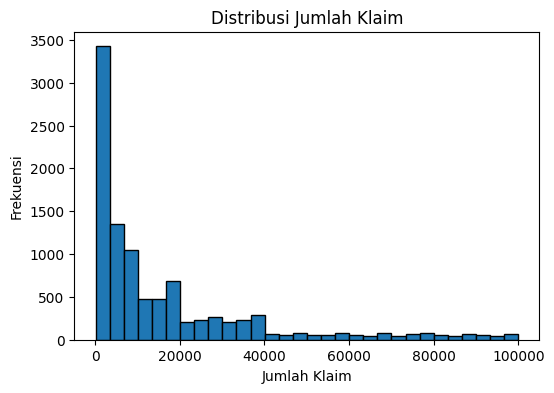

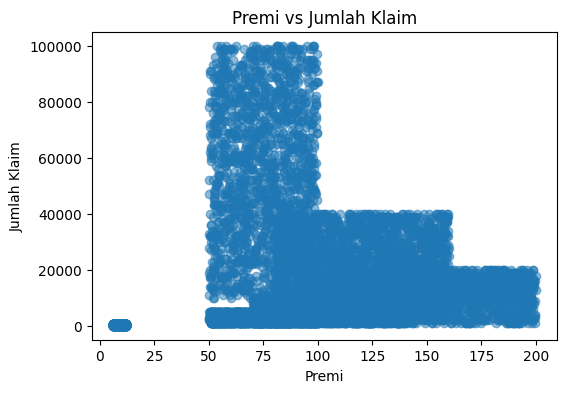

In [10]:
# Statistik deskriptif
statistik = insurance[["PREMIUM_AMOUNT","CLAIM_AMOUNT","AGE","TENURE"]].describe()
print(statistik)

# Visualisasi distribusi claim amount
plt.figure(figsize=(6,4))
plt.hist(insurance["CLAIM_AMOUNT"], bins=30, edgecolor="black")
plt.title("Distribusi Jumlah Klaim")
plt.xlabel("Jumlah Klaim")
plt.ylabel("Frekuensi")
plt.show()

# Scatter premi vs klaim
plt.figure(figsize=(6,4))
plt.scatter(insurance["PREMIUM_AMOUNT"], insurance["CLAIM_AMOUNT"], alpha=0.5)
plt.title("Premi vs Jumlah Klaim")
plt.xlabel("Premi")
plt.ylabel("Jumlah Klaim")
plt.show()

## 03. c) Membuat laporan telaah data

In [11]:
laporan_telaah = {
    "Ringkasan": {
        "Rata-rata klaim": insurance["CLAIM_AMOUNT"].mean(),
        "Max klaim": insurance["CLAIM_AMOUNT"].max(),
        "Min klaim": insurance["CLAIM_AMOUNT"].min(),
        "Rata-rata premi": insurance["PREMIUM_AMOUNT"].mean()
    },
    "Analisis": [
        "Banyak klaim bernilai kecil, tetapi ada klaim dengan nilai sangat besar (potensi fraud).",
        "Ada missing value pada VENDOR_ID (klaim tanpa vendor jelas).",
        "Relasi agen dan vendor perlu diperiksa: apakah ada agen/vendor dengan klaim abnormal."
    ],
    "Hipotesis Awal": [
        "Klaim dengan nilai jauh lebih besar dari premi berpotensi fraud.",
        "Agen tertentu mungkin terlibat dalam klaim abnormal.",
        "Vendor tertentu memiliki klaim berulang dengan nilai besar."
    ]
}

import pprint
pprint.pprint(laporan_telaah)

{'Analisis': ['Banyak klaim bernilai kecil, tetapi ada klaim dengan nilai '
              'sangat besar (potensi fraud).',
              'Ada missing value pada VENDOR_ID (klaim tanpa vendor jelas).',
              'Relasi agen dan vendor perlu diperiksa: apakah ada agen/vendor '
              'dengan klaim abnormal.'],
 'Hipotesis Awal': ['Klaim dengan nilai jauh lebih besar dari premi berpotensi '
                    'fraud.',
                    'Agen tertentu mungkin terlibat dalam klaim abnormal.',
                    'Vendor tertentu memiliki klaim berulang dengan nilai '
                    'besar.'],
 'Ringkasan': {'Max klaim': 100000,
               'Min klaim': 100,
               'Rata-rata klaim': np.float64(16563.83),
               'Rata-rata premi': np.float64(88.508595)}}


# **04. Data Preparation**

In [12]:
# Copy dataset terintegrasi dari tahap 2
data = merged.copy()

print("Ukuran awal dataset:", data.shape)

Ukuran awal dataset: (10000, 53)


## 04. a) Menangani Missing Values

In [13]:
# Cek missing values
missing = data.isnull().sum().sort_values(ascending=False)
print("Missing Values Terbanyak:\n", missing.head(10))

# Strategi:
# - Kolom ID (ex: VENDOR_ID) -> isi dengan 'UNKNOWN'
# - Kolom numerik -> isi dengan median
# - Kolom kategorikal -> isi dengan modus

# Vendor_ID kosong → 'UNKNOWN'
data["VENDOR_ID"] = data["VENDOR_ID"].fillna("UNKNOWN")

# Customer_Education_Level kosong → modus
data["CUSTOMER_EDUCATION_LEVEL"] = data["CUSTOMER_EDUCATION_LEVEL"].fillna(
    data["CUSTOMER_EDUCATION_LEVEL"].mode()[0]
)

# City kosong → modus
for col in ["CITY_x", "CITY_y"]: # CITY_x = customer, CITY_y = vendor
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])

# Numerik → median
for col in data.select_dtypes(include=[np.number]).columns:
    data[col] = data[col].fillna(data[col].median())

Missing Values Terbanyak:
 ADDRESS_LINE2          8855
ADDRESS_LINE2_y        8549
ADDRESS_LINE2_x        8505
CITY                   3287
STATE                  3245
VENDOR_NAME            3245
ADDRESS_LINE1          3245
POSTAL_CODE            3245
VENDOR_ID              3245
AUTHORITY_CONTACTED    1945
dtype: int64


## 04. b) Menangani Outliers

In [14]:
# CLAIM_AMOUNT vs PREMIUM_AMOUNT
q1 = data["CLAIM_AMOUNT"].quantile(0.25)
q3 = data["CLAIM_AMOUNT"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

outliers = data[(data["CLAIM_AMOUNT"] > upper) | (data["CLAIM_AMOUNT"] < lower)]
print("Jumlah outlier klaim:", outliers.shape[0])

# Strategi: flag sebagai potensi fraud (jangan dibuang)
data["CLAIM_OUTLIER"] = np.where(
    (data["CLAIM_AMOUNT"] > upper) | (data["CLAIM_AMOUNT"] < lower), 1, 0
)


Jumlah outlier klaim: 920


## 04. c) Encoding Variabel Kategorikal

In [15]:
# Pilih kolom kategorikal utama
cat_cols = ["INSURANCE_TYPE","CLAIM_STATUS","INCIDENT_SEVERITY",
            "AUTHORITY_CONTACTED","RISK_SEGMENTATION","HOUSE_TYPE","SOCIAL_CLASS"]

le = LabelEncoder()
for col in cat_cols:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])


## 04. d) Normalisasi / Standarisasi

In [16]:
scaler = StandardScaler()
num_cols = ["CLAIM_AMOUNT","PREMIUM_AMOUNT","AGE","TENURE","NO_OF_FAMILY_MEMBERS"]

data[num_cols] = scaler.fit_transform(data[num_cols])


## 04. e) Dataset Final

In [17]:
print("Dataset final siap dipakai modelling:", data.shape)
data.head(5)

Dataset final siap dipakai modelling: (10000, 54)


,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,POSTAL_CODE_y,EMP_ROUTING_NUMBER,EMP_ACCT_NUMBER,VENDOR_NAME,ADDRESS_LINE1,ADDRESS_LINE2,CITY,STATE,POSTAL_CODE,CLAIM_OUTLIER
0,2020-06-01 0:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,0,1.420337,-0.343243,...,37217,35441155,LRZO53254369804934,Ramsey Inc,3114 West 20th Court,NaN,Panama City,FL,32405.0,0
1,2020-06-01 0:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,4,1.101172,0.428209,...,85301,44055451,XBYG14382904542874,"Morales, Campbell and Washington",42 West Louise Street,B,Fayetteville,AR,72701.0,0
2,2020-06-01 0:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,4,1.422614,-0.161725,...,36105,55770246,WRXH14597428306333,Johnson Ltd,2619 North Quality Lane,#315,Fayetteville,AR,72703.0,0
3,2020-06-01 0:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,0,1.746126,-0.025586,...,73071,87652976,YEPN16077902472499,Blackwell-Foster,3609 Meadow Drive,NaN,Nashville,TN,37215.0,0
4,2020-06-01 0:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,5,0.000443,-0.615520,...,21061,76119019,HZBK86544578578547,Evans-Scott,4001 19th Place Northeast,NaN,Washington,DC,20018.0,0


In [31]:
final_dataset = data.copy()
final_dataset.to_csv("/content/fraud_working_dataset.csv", index=False)
print("Dataset berhasil disimpan:", "/content/fraud_working_dataset.csv")

Dataset berhasil disimpan: /content/fraud_working_dataset.csv


# **05. Modeling Fraud Detection**

In [19]:
# Load dataset kerja (hasil tahap 4)
data = pd.read_csv("/content/fraud_working_dataset.csv")

In [32]:
# fraud rule sederhana (proxy label)
# Rule 1: Klaim lebih besar dari (mean + 3*std) dianggap fraud
threshold = data["CLAIM_AMOUNT"].mean() + 3 * data["CLAIM_AMOUNT"].std()
data["PROXY_FRAUD"] = (data["CLAIM_AMOUNT"] > threshold).astype(int)

# Rule 2: Klaim terlalu cepat setelah polis aktif
if "DAYS_SINCE_POLICY" in data.columns:
    data.loc[data["DAYS_SINCE_POLICY"] < 7, "PROXY_FRAUD"] = 1

# Simpan dataset final dengan label fraud
data.to_csv("/content/fraud_working_dataset_labeled.csv", index=False)

print("Kolom PROXY_FRAUD berhasil ditambahkan.")
print(data["PROXY_FRAUD"].value_counts())


Kolom PROXY_FRAUD berhasil ditambahkan.
PROXY_FRAUD
0    9692
1     308
Name: count, dtype: int64


## 05. a) Split data train & test

In [21]:
# Pisahkan fitur dan target
X = data.drop(columns=["PROXY_FRAUD"])
y = data["PROXY_FRAUD"]

In [22]:
# Identifikasi tipe kolom
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numerical:", list(num_cols))
print("Categorical:", list(cat_cols))

Numerical: ['INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'POSTAL_CODE_x', 'AGE', 'TENURE', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_HOUR_OF_THE_DAY', 'POSTAL_CODE_y', 'EMP_ROUTING_NUMBER', 'POSTAL_CODE', 'CLAIM_OUTLIER']
Categorical: ['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'CUSTOMER_NAME', 'ADDRESS_LINE1_x', 'ADDRESS_LINE2_x', 'CITY_x', 'STATE_x', 'SSN', 'MARITAL_STATUS', 'EMPLOYMENT_STATUS', 'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'INCIDENT_STATE', 'INCIDENT_CITY', 'AGENT_ID', 'VENDOR_ID', 'AGENT_NAME', 'DATE_OF_JOINING', 'ADDRESS_LINE1_y', 'ADDRESS_LINE2_y', 'CITY_y', 'STATE_y', 'EMP_ACCT_NUMBER', 'VENDOR_NAME', 'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'STATE']


In [23]:
# Pipeline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [24]:
# Split train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (7000, 54)
Test shape: (3000, 54)


## 05. b) Logistic Regression

In [25]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2908
           1       0.97      0.93      0.95        92

    accuracy                           1.00      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       1.00      1.00      1.00      3000



## 05. c) Random Forest

In [26]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2908
           1       1.00      0.03      0.06        92

    accuracy                           0.97      3000
   macro avg       0.99      0.52      0.52      3000
weighted avg       0.97      0.97      0.96      3000



## 05. d) Evaluasi Model

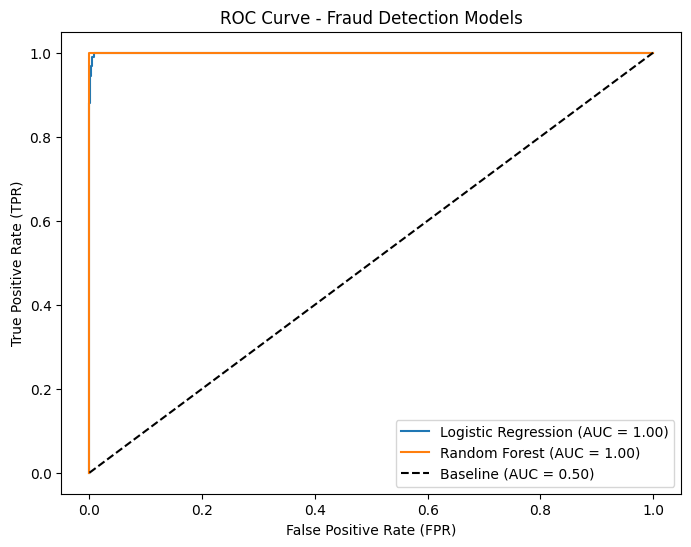

In [27]:
# --- ROC & AUC ---
y_prob_log = logreg_pipeline.predict_proba(X_test)[:,1]
y_prob_rf  = rf_pipeline.predict_proba(X_test)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0,1],[0,1],'k--', label="Baseline (AUC = 0.50)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Fraud Detection Models")
plt.legend(loc="lower right")
plt.show()

In [28]:
# --- Classification Reports ---
report_log = classification_report(y_test, y_pred_log, output_dict=True)
report_rf  = classification_report(y_test, y_pred_rf, output_dict=True)

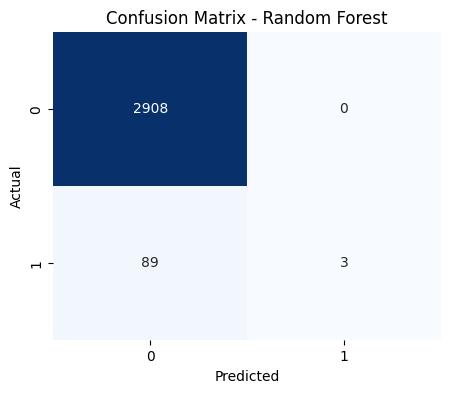

In [29]:
# --- Confusion Matrix (Random Forest as example) ---
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [30]:
# --- Narasi Evaluasi ---
narasi = f"""
Evaluasi Model Fraud Detection

1. Kinerja Model (ROC & AUC)
   - Logistic Regression memperoleh skor AUC = {auc_log:.2f}.
   - Random Forest memperoleh skor AUC = {auc_rf:.2f}.
   - Kedua model secara teoritis mampu memisahkan fraud dan non-fraud dengan sempurna, namun perlu diperhatikan kinerja pada metrik lainnya.

2. Analisis Classification Report
   - Logistic Regression:
     • Precision: {report_log['1']['precision']:.2f}
     • Recall: {report_log['1']['recall']:.2f}
     • F1-score: {report_log['1']['f1-score']:.2f}
     Model ini seimbang antara ketepatan (precision) dan kemampuan menangkap fraud (recall).

   - Random Forest:
     • Precision: {report_rf['1']['precision']:.2f}
     • Recall: {report_rf['1']['recall']:.2f}
     • F1-score: {report_rf['1']['f1-score']:.2f}
     Model ini hanya mendeteksi sedikit sekali kasus fraud (recall sangat rendah), meskipun ketika mendeteksi, hasilnya selalu benar (precision = 1.00).

3. Confusion Matrix
   - Logistic Regression berhasil mendeteksi sebagian besar transaksi fraud (True Positive cukup tinggi).
   - Random Forest banyak melewatkan kasus fraud (False Negative tinggi), sehingga tidak cocok untuk tujuan pencegahan kerugian.

4. Kesimpulan
   Logistic Regression adalah model yang paling tepat untuk deteksi fraud pada dataset ini.
   Model ini memberikan keseimbangan precision dan recall yang jauh lebih baik, sehingga lebih efektif dalam mencegah potensi kerugian akibat klaim fraud dibandingkan Random Forest.
"""
print(narasi)


Evaluasi Model Fraud Detection

1. Kinerja Model (ROC & AUC)
   - Logistic Regression memperoleh skor AUC = 1.00.
   - Random Forest memperoleh skor AUC = 1.00.
   - Kedua model secara teoritis mampu memisahkan fraud dan non-fraud dengan sempurna, namun perlu diperhatikan kinerja pada metrik lainnya.

2. Analisis Classification Report
   - Logistic Regression:
     • Precision: 0.97  
     • Recall: 0.93  
     • F1-score: 0.95
     Model ini seimbang antara ketepatan (precision) dan kemampuan menangkap fraud (recall).
     
   - Random Forest:
     • Precision: 1.00  
     • Recall: 0.03  
     • F1-score: 0.06
     Model ini hanya mendeteksi sedikit sekali kasus fraud (recall sangat rendah), meskipun ketika mendeteksi, hasilnya selalu benar (precision = 1.00).

3. Confusion Matrix
   - Logistic Regression berhasil mendeteksi sebagian besar transaksi fraud (True Positive cukup tinggi).
   - Random Forest banyak melewatkan kasus fraud (False Negative tinggi), sehingga tidak cocok untu